# Banana, Apple, or Other Classifier – End-to-End Deep Learning Workflow

## 1. Imports

In [1]:
import os
import sys
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from pathlib import Path
from torchvision import transforms
import matplotlib.pyplot as plt


## 2. Dataset Overview & EDA

In [2]:


dataset_dir = Path("../../training/dataset")
splits = ['train', 'val', 'test']
overview = {split: defaultdict(int) for split in splits}

for split in splits:
    split_dir = dataset_dir / split
    for class_dir in split_dir.iterdir():
        if class_dir.is_dir():
            overview[split][class_dir.name] += len(list(class_dir.glob("*.jpg")))

import pandas as pd
df = pd.DataFrame(overview).fillna(0).astype(int)
df


,train,val,test
apple,91,19,21
banana,91,19,21
other,141,30,31


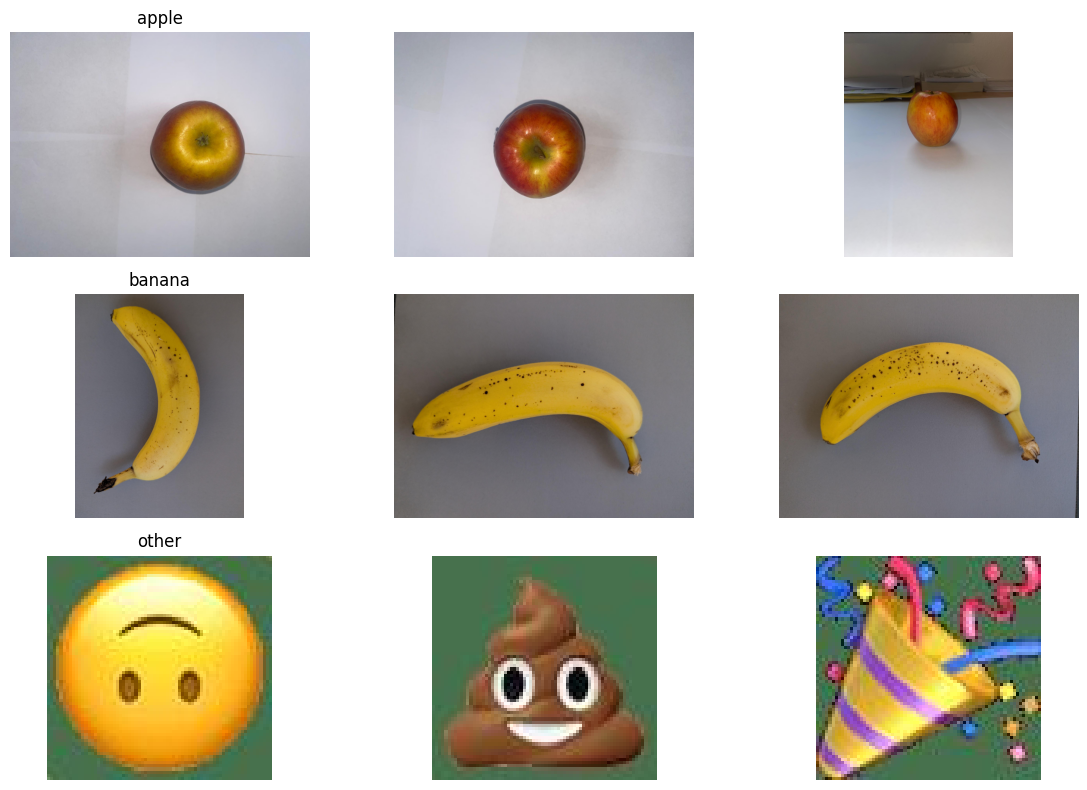

In [3]:
# Show sample images from each class
sample_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def show_samples(split='train', samples_per_class=3):
    split_dir = dataset_dir / split
    fig, axs = plt.subplots(len(os.listdir(split_dir)), samples_per_class, figsize=(12, 8))
    for row_idx, class_name in enumerate(os.listdir(split_dir)):
        class_dir = split_dir / class_name
        images = list(class_dir.glob("*.jpg"))[:samples_per_class]
        for col_idx, img_path in enumerate(images):
            image = Image.open(img_path).convert("RGB")
            axs[row_idx, col_idx].imshow(image)
            axs[row_idx, col_idx].axis("off")
            if col_idx == 0:
                axs[row_idx, col_idx].set_title(class_name)
    plt.tight_layout()
    plt.show()

show_samples()


## 3. Model & Training Setup

In [4]:
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from model import BananaOrAppleClassifier
from data import get_dataloaders


## 4. Train the Model

d:\New Programming Projects (Pycharm, VS Code, e.t.c.)\PDL\BananaOrApple_Project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 |  37.59s | Train Acc: 0.5666 | Val Acc: 0.8382
 Saved best model
Epoch 2 |  31.06s | Train Acc: 0.7988 | Val Acc: 0.9706
 Saved best model
Epoch 3 |  38.88s | Train Acc: 0.8204 | Val Acc: 0.9412
Epoch 4 |  35.54s | Train Acc: 0.8297 | Val Acc: 0.9706
Epoch 5 |  29.51s | Train Acc: 0.8607 | Val Acc: 0.9853
 Saved best model
Epoch 6 |  30.75s | Train Acc: 0.8576 | Val Acc: 0.9559
Epoch 7 |  38.13s | Train Acc: 0.8854 | Val Acc: 0.9412
Epoch 8 |  29.37s | Train Acc: 0.8669 | Val Acc: 0.9412
Epoch 9 |  26.23s | Train Acc: 0.8700 | Val Acc: 0.9853
Epoch 10 |  39.84s | Train Acc: 0.8978 | Val Acc: 0.9706
Epoch 11 |  42.52s | Train Acc: 0.9071 | Val Acc: 0.9706
Epoch 12 |  28.75s | Train Acc: 0.9102 | Val Acc: 0.9559
Epoch 13 |  28.30s | Train Acc: 0.8947 | Val Acc: 0.9412
Epoch 14 |  28.32s | Train Acc: 0.8978 | Val Acc: 0.9706
Epoch 15 |  31.23s | Train Acc: 0.9040 | Val Acc: 0.9559
Epoch 16 |  40.96s | Train Acc: 0.8885 | Val Acc: 0.9706
Epoch 17 |  35.58s | Train Acc: 0.8885 | Va

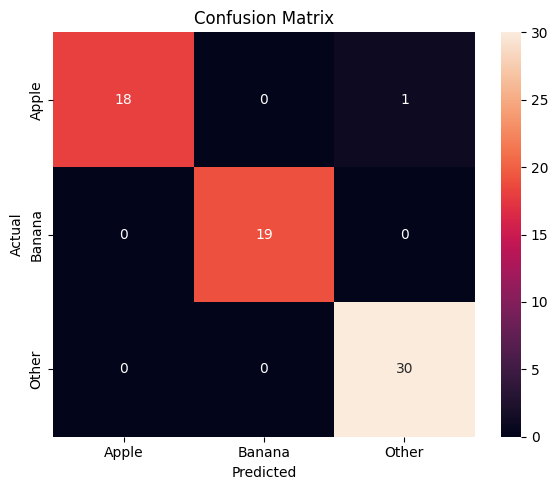

In [5]:
from train import main
main()

## 5. Evaluation on Test Set

Test Set Classification Report:
              precision    recall  f1-score   support

       apple       0.87      0.95      0.91        21
      banana       0.95      0.95      0.95        21
       other       0.93      0.87      0.90        31

    accuracy                           0.92        73
   macro avg       0.92      0.93      0.92        73
weighted avg       0.92      0.92      0.92        73



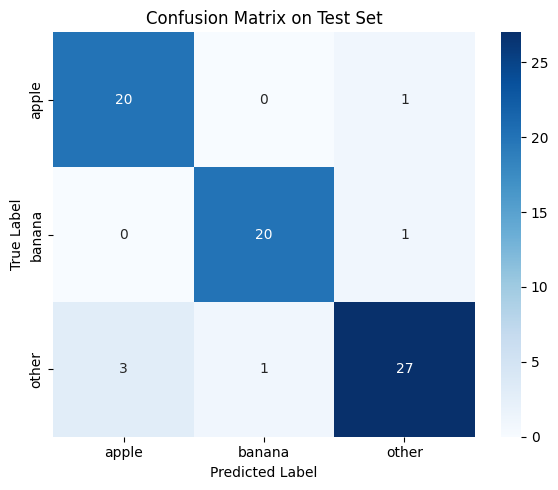

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Setup
model = BananaOrAppleClassifier()
model.load_state_dict(torch.load("../../hf_app/banana_or_apple.pt", map_location=device))
model.to(device)
model.eval()

# --- Define test transforms
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Load test data
test_dataset = ImageFolder(dataset_dir / "test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Inference
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification report
print("Test Set Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# --- Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()